***
# Downstream analysis with BASiCS

**BASiCS** (Bayesian Analysis of Single-Cell Sequencing data) is an integrated Bayesian hierarchical model where: 

1. Cell-specific normalization constants are estimated as part of the model parameters, 

2. Technical variability is quantified based on spike-in genes that are artificially introduced to each analysed cells lysate and 

3. The total variability of the expression counts is decomposed into technical and biological components. 

BASiCS also provides an intuitive detection criterion for highly (or lowly) variable genes within the population of cells under study. This is formalized by means of tail posterior probabilities associated to high (or low) biological cell-to-cell variance contributions, quantities that can be easily interpreted by applied users. 

Here, we demonstrate how to use BASiCS using a simulated dataset. 



***

## The BASiCS model

Throughout, we analyse the expression counts of $q$ genes, where $q_0$ are expressed in the population of cells under study (biological genes) and the remaining $q-q_0$ are spike-in (technical) genes. Let $X_{ij}$ be a random variable representing the expression count of a gene $i$ in cell $j$  ($i=1,\ldots,q$; $j=1,\ldots,n$). BASiCS is based on the following hierarchical model:
$$X_{ij}  \big| \mu_i, \phi_j, \nu_j, \rho_{ij} \sim \left\{ \begin{array}{ll} \mbox{Poisson}(\phi_j \nu_j \mu_i \rho_{ij}), \mbox{  for }i=1,\ldots,q_0, j=1,\ldots,n \\ \mbox{Poisson}(\nu_j \mu_i), \mbox{  for }i=q_0+1,\ldots,q, j=1,\ldots,n, \end{array} \right.$$

where $\nu_j$ and $\rho_{ij}$ are mutually independent random effects such that $\nu_j|s_j,\theta \sim \mbox{Gamma}(1/\theta,1/ (s_j \theta))$ and $\rho_{ij} | \delta_i \sim \mbox{Gamma} (1/\delta_i,1/\delta_i)$[^footnoteGamma]. In the previous equation, the model parameters can be interpreted as:

* $\mu_i$: normalized expression rate of a gene $i$ in the population of cells under study. In case of the spike-in technical genes, $\mu_i$ is assumed to be known (and equal to the input number of molecules of the corresponding spike-in gene).

* $\rho_{ij}$: random effects related to biological cell-to-cell expression heterogeneity of a gene $i$ across the population of cells under study. 

* $\delta_i$: variance of $\rho_{ij}$, controlling the strength of the biological cell-to-cell expression heterogeneity of a gene $i$ across the population of cells under study. 

* $\phi_j$: cell-specific normalizing constants related to differences in mRNA content. For identifiability reasons, we impose the constrain: $\sum_{j=1}^n \phi_j = n$. 

* $s_j$: cell-specific normalizing constants related to differences in capture efficiency (when analyzing UMI based expression counts) and other amplification biases such as sequencing depth (when analyzing non-UMI based expression counts, as generated by standard scRNA-seq experiments).

* $\nu_j$: random effects related to cell-to-cell technical variability. These parameters oscilate around the normalizing constants $s_j$.

* $\theta$: variance of $\nu_j$, controlling the strenght of cell-to-cell technical variability. 

[^footnoteGamma]: We parametrize the Gamma distribution such that if $X \sim \mbox{Gamma}(a,b)$, then $\mbox{E}(X)=a/b$ and $\mbox{var}(X)=a/b^2$.
***
###  The input dataset

The input dataset for BASiCS must contain the following 3 elements:

* `Counts`: a matrix of raw expression counts with dimensions $q$ times $n$. First $q_0$ rows must correspond to biological genes. Last $q-q_0$ rows must correspond to technical spike-in genes.

* `Tech`: a vector of `TRUE`/`FALSE` elements with length $q$. If `Tech[i] = FALSE` the gene `i` is biological; otherwise the gene is spike-in.

* `SpikeInput`: a vector of length $q-q_0$ whose elements contain the input number of molecules for the spike-in genes (amount per cell).

These elements must be stored into an object of class `BASiCS_Data`.

In [2]:
import subprocess, os, csv, signal, pysam, collections, optparse, sys, tempfile, re, optparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import rpy2.interactive as r
import rpy2.interactive.packages # this can take few seconds
import time
from ZIFA import ZIFA
from ZIFA import block_ZIFA
import pylab

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [3]:
%load_ext rpy2.ipython

In [5]:
%%R
library("dplyr")
library("edgeR")
library("ggplot2")
library("cowplot")
library("BASiCS")
library("scde")
library(repr)
library(biomaRt)
library(GO.db)
theme_set(theme_bw(base_size = 16))

In [6]:
%%R
CountData <- read.csv('/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/AllHtseqCounts.csv',check.names=FALSE,row.names=1)
CellNumber <- dim(CountData)[2]

## Generating summary

In [7]:
%%R
summary_data <- data.frame(CellNumber= character(CellNumber), Assigned_Reads=numeric(CellNumber),alignment_not_unique=numeric(CellNumber),ambiguous=numeric(CellNumber),no_feature=numeric(CellNumber),not_aligned=numeric(CellNumber),too_low_aQual=numeric(CellNumber ) )
summary_data$CellNumber <- colnames(CountData)
summary_data$Assigned_Reads <- apply(CountData[grep("ENSMUSG", rownames(CountData)), ],2,sum) 
summary_data$alignment_not_unique <- t(CountData[grep("alignment_not_unique", rownames(CountData)), ])
summary_data$ambiguous <- t(CountData[grep("ambiguous", rownames(CountData)), ])
summary_data$no_feature <- t(CountData[grep("no_feature", rownames(CountData)), ])
summary_data$not_aligned <- t(CountData[grep("not_aligned", rownames(CountData)), ])
summary_data$too_low_aQual <- t(CountData[grep("too_low_aQual", rownames(CountData)), ])

#apply(CountData[grep("ENSMUSG", rownames(CountData)), ],2,sum) 

In [9]:
%%R
ERCCData <- read.csv('/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/AllERCC_Counts.csv',check.names=FALSE,row.names=1)

In [12]:
%%R
ERCC_reads <- apply(ERCCData[grep("ERCC", rownames(ERCCData)), ],2,sum)
ercc_reads_plot <- ggplot(ERCC_reads,
                   aes(x = factor(colnames(ERCCData)), y = ERCC_reads,
                   fill = factor(colnames(ERCCData))), height = 600, width = 2000) +
                   geom_violin(alpha = .5) + 
                   geom_boxplot(alpha = .01, width = .2, position = position_dodge(width = .9)) +
                   labs(x = "", y = "ERCC molecules", title = "Total ERCC molecule counts per cell") +
                   theme(axis.text.x = element_text(hjust=1, angle = 45))

#theme_set(theme_bw(base_size = 16))
print(ercc_reads_plot)


Error: ggplot2 doesn't know how to deal with data of class integer


In [15]:
%%R
molecules_filter <- ERCCData
molecules_filter <- molecules_filter[rowSums(molecules_filter)>0,]
dim(molecules_filter)

[1] 82 96


Filtering the Cells

In [24]:
%%R -o cd
# omit the non-mapped gene information
cd = CountData[1:(dim(CountData)[1]-5),]
# omit genes that are never detected
#cd <- cd[rowSums(cd)>0, ]
# omit cells with very poor coverage
#cd <- cd[, colSums(cd)>1e4]
#CellNumber <- dim(cd)[2]
print(dim(cd))

[1] 45232    96


In [14]:
%%R
spike <- read.table("/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/expected-ercc-molecules.txt", header=TRUE, sep = "\t", stringsAsFactors = FALSE)

In [18]:
%%R
head(spike)

          id conc_mix1 ercc_molecules_well
1 ERCC-00130 30000.000          4877.93485
2 ERCC-00004  7500.000          1219.48371
3 ERCC-00136  1875.000           304.87093
4 ERCC-00108   937.500           152.43546
5 ERCC-00116   468.750            76.21773
6 ERCC-00092   234.375            38.10887


In [21]:
%%R
spike_input <- data.frame(Spike=spike$id, Read=spike$ercc_molecules_well)
#names(spike_input) <- spike$id[spike$id %in% rownames(molecules_filter)]
#spike_input <- data.frame(spike_input[order(names(spike_input))])

Filtering the cells and genes

In [34]:
%%R
cd = CountData[1:(dim(CountData)[1]-5),]
# omit genes that are never detected
cd <- cd[rowSums(cd)>10, ]
# omit cells with very poor coverage
cd <- cd[, colSums(cd)>40000]
#CellNumber <- dim(cd)[2]
print(dim(cd))

[1] 9832   56


In [52]:
%%R
# From ERCCData we take only the ERCC for which the input value is given. In the fasta file, downloaded from
# https://www-s.nist.gov/srmors/view_datafiles.cfm?srm=2374 has more ERCC than the input values
SpikeExp <- ERCCData[rownames(ERCCData) %in% spike_input$Spike, ]
SpikeExp <- SpikeExp[, colnames(SpikeExp) %in% colnames(cd)]
SpikeExp <- SpikeExp[rowSums(SpikeExp)>10,]
Tech <- c(rep(FALSE, dim(cd)[1]), rep(TRUE, dim(SpikeExp)[1]))
SpikeInput <- spike_input[spike_input$Spike %in% rownames(SpikeExp),]
Counts <- as.matrix(rbind(cd, SpikeExp))
write.table(Counts, "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/BASiCS_OUTPUT/AllCombinedCounts_v2.txt", quote = FALSE,
            sep = "\t", col.names = NA)


## Fitting the BASiCS model

The BASiCS model is fitted using a Bayesian approach by means of an Adaptive Metropolis within Gibbs Sampling algorithm[^RobertsRosenthal2009]. We assume prior independence between all model parameters (except within the $\phi_j$'s, for which its total sum is constrained), using a flat *non informative* prior for the normalised expression rates $\mu_1,\ldots,\mu_{q_0}$ and proper *informative* prior distributions for all other model parameters. The adopted prior is given by

* $\pi(\mu_i) \propto \mu_i^{-1}$ for $i=1, \ldots, q_0$,

* $\delta_i \sim \mbox{Gamma}(a_{\delta},b_{\delta})$ for $i=1, \ldots, q_0$,

* $n^{-1} \phi = n^{-1} (\phi_1, \ldots, \phi_n)'  \sim \mbox{Dirichlet}(p)$ with $p = (p_1,\ldots,p_n)'$ and each $p_j>0$,

* $s_j \sim \mbox{Gamma}(a_s,b_s)$,

* $\theta \sim \mbox{Gamma}(a_{\theta},b_{\theta})$, 

for fixed hyper-parameter values $a_{\delta}, b_{\delta}$, $p, a_s, b_s, a_{\theta}$ and $b_{\theta}$[^Prior]. As a default option, the sampler assumes all these hyper-parameters are equal to 1 (in case of $p$, we use $p_1 = p_2 = \cdots = p_n = 1$). However, the user can modify this option. 

[^Prior]: The analysis of simulated and real datasets suggested that the choice of these hyper-parameters does not have major consequences in posterior inference.

[^RobertsRosenthal2009]: Roberts GO, Rosenthal JS (2009). Examples of adaptive MCMC. Journal of Computational and Graphical Statistics 18: 349-367. DOI: 10.1198/jcgs.2009.06134

The function `BASiCS_MCMC` runs the sampler. It requires 4 basic arguments:

* `Data`: an object of class `BASiCS_Data`

* `N`: the total number of iterations for the algorithm

* `Thin`: thinning period for the algorithm (i.e. the output will only store parameter draws every `Thin` iterations)

* `Burn`: burning period for the algorithm (i.e. the initial `Burn` iterations are discarded)

In [53]:
%%R
basics_data <- newBASiCS_Data(Counts, Tech, SpikeInput)

An object of class BASiCS_Data
 Dataset contains 9867 genes (9832 biological and 35 technical) and 56 cells.
 Elements (slots): Counts, Tech, SpikeInput, GeneNames and BatchInfo.
 The data contains 1 batch.

NOTICE: BASiCS requires a pre-filtered dataset 
    - You must remove poor quality cells before creating the BASiCS data object 
    - We recommend to pre-filter very lowly expressed transcripts before creating the object. 
      Inclusion criteria may vary for each data. For example, remove transcripts 
          - with very low total counts across of all of the samples 
          - that are only expressed in a few cells 
            (by default genes expressed in only 1 cell are not accepted) 
          - with very low total counts across the samples where the transcript is expressed 

 BASiCS_Filter can be used for this purpose 


In [54]:
%%R
store_dir <- "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/BASiCS_OUTPUT_V2"
run_name <- "batch-clean"
if (file.exists(paste0(store_dir, "/chain_phi_", run_name, ".txt"))) {
  chain_mu = as.matrix(fread(paste0(store_dir, "/chain_mu_", run_name, ".txt")))
  chain_delta = as.matrix(fread(paste0(store_dir, "/chain_delta_", run_name, ".txt")))
  chain_phi = as.matrix(fread(paste0(store_dir, "/chain_phi_", run_name, ".txt")))
  chain_s = as.matrix(fread(paste0(store_dir, "/chain_s_", run_name, ".txt")))
  chain_nu = as.matrix(fread(paste0(store_dir, "/chain_nu_", run_name, ".txt")))
  chain_theta = as.matrix(fread(paste0(store_dir, "/chain_theta_", run_name, ".txt")))

  mcmc_output <- newBASiCS_Chain(mu = chain_mu, delta = chain_delta,
                                 phi = chain_phi, s = chain_s,
                                 nu = chain_nu, theta = chain_theta)

  time_total <- readRDS(paste0(store_dir, "/time_total_", run_name, ".rds"))
} else {
  time_start <- Sys.time()
  mcmc_output <- BASiCS_MCMC(basics_data, N = 40000, Thin = 10, Burn = 20000,
                             PrintProgress = TRUE, StoreChains = TRUE,
                             StoreDir = store_dir, RunName = run_name)
  time_end <- Sys.time()
  time_total <- difftime(time_end, time_start, units = "hours")
  saveRDS(time_total, paste0(store_dir, "/time_total_", run_name, ".rds"))
}

--------------------------------------------------------------------
MCMC sampler has been started: 40000 iterations to go.
--------------------------------------------------------------------
--------------------------------------------------------------------
MCMC iteration 0 out of 40000 has been completed.
--------------------------------------------------------------------
Current draws of some selected parameters are displayed below.
mu (gene 1): 5.10153
delta (gene 1): 2.92488
phi (cell 1): 0.734126
s (cell 1): 0.0236914
nu (cell 1): 0.0149104
theta: 0.672904
--------------------------------------------------------------------
Current proposal variances for Metropolis Hastings updates (log-scale).
LSmu (gene 1): -4
LSdelta (gene 1): -2
LSphi: 11
LSnu (cell 1): -4.95117
LStheta: -4
--------------------------------------------------------------------
MCMC iteration 20 out of 40000 has been completed.
--------------------------------------------------------------------
Current draw

In [55]:
%%R
mcmc_summary <- Summary(mcmc_output)

In [56]:
%%R
mcmc_summary

An object of class BASiCS_Summary
 Contains posterior medians and limits of HPD 95% interval for BASiCS parameters.
 Dataset contains 9832 genes (9832 biological and 0 technical) and 56 cells (1 batch). 
 Elements (slots): mu, delta, phi, s, nu and theta.


In [113]:
%%R
cor(t(ERCCData))

             ERCC-00002   ERCC-00003   ERCC-00004   ERCC-00007   ERCC-00009
ERCC-00002  1.000000000 -0.053178144 -0.056479943 -0.050256124 -0.038718824
ERCC-00003 -0.053178144  1.000000000 -0.028660944  0.058182992 -0.018602037
ERCC-00004 -0.056479943 -0.028660944  1.000000000 -0.023057874 -0.016218340
ERCC-00007 -0.050256124  0.058182992 -0.023057874  1.000000000 -0.014965432
ERCC-00009 -0.038718824 -0.018602037 -0.016218340 -0.014965432  1.000000000
ERCC-00012 -0.103094067 -0.046814099 -0.034475026 -0.037662179  0.397359707
ERCC-00013 -0.063280245 -0.037805795  0.089923536 -0.030414953 -0.021393127
ERCC-00014  0.076466565 -0.076501055 -0.042758513  0.026776817  0.505624554
ERCC-00016  0.338710727 -0.018602037 -0.016218340 -0.014965432 -0.010526316
ERCC-00017  0.003956564 -0.047459718  0.003879717 -0.054918714 -0.038628468
ERCC-00018  0.074762162 -0.020739889 -0.037053779 -0.034191281 -0.024049304
ERCC-00022 -0.042088731 -0.018602037 -0.016218340 -0.014965432 -0.010526316
ERCC-00023  

## Cell-specific normalizing constants
BASiCS models two cell-specific parameters. 

* $\phi_j$: The cell-specific normalizing constants related to differences in mRNA content. For identifiability reasons, BASiCS impose the constrain: $\sum_{j=1}^{n} \phi_j = n$ . 
* $s_j$: Cell specific normalizing constant related to differences in capture efficiency (when analyzing UMI based expression counts) and other amplification biases such as sequencing depth (when analyzing non-UMI based expression counts, as generated by standard scRNA-seq experiments)

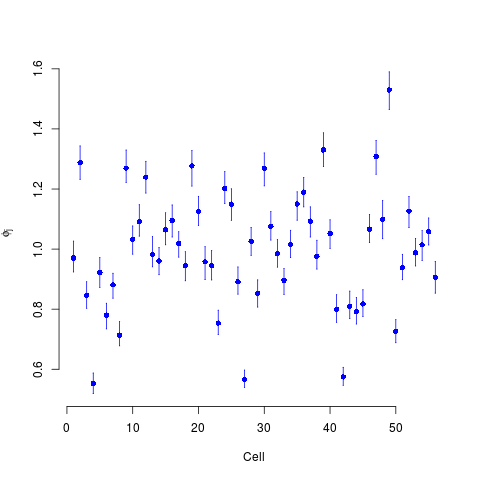

In [57]:
%%R
plot(mcmc_summary, Param = "phi")

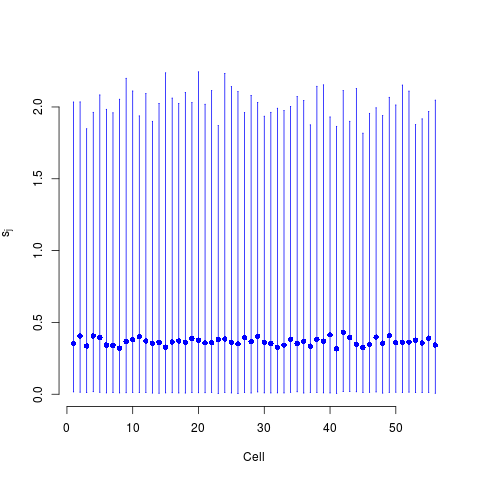

In [58]:
%%R
plot(mcmc_summary, Param = "s")

In [59]:
%%R
phi <- displaySummaryBASiCS(mcmc_summary, Param = "phi")
s <- displaySummaryBASiCS(mcmc_summary, Param = "s")
#parameters <- cbind(phi, s)
gene_count <- colSums(counts(basics_data, type = "biological"))
ercc_count <- colSums(counts(basics_data, type = "technical"))
parameters <- cbind(phi, s, gene_count, ercc_count)


In [60]:
%%R
#rownames(parameters) <- c(1:96)
parameters <- data.frame(parameters)

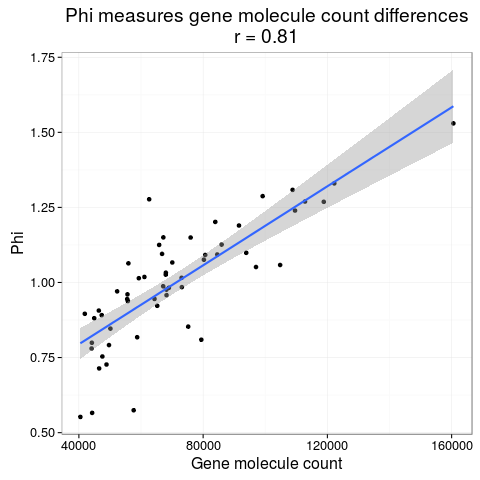

In [61]:
%%R
#png("phi_vs_Gene_Counts.png")
phi_gene_count <- ggplot(parameters, aes(x = gene_count, y = Phi)) +
  geom_point() +
  geom_smooth(method = "lm") +
  labs(x = "Gene molecule count",
       title = paste0("Phi measures gene molecule count differences\nr = ",
                      round(cor(parameters$gene_count, parameters$Phi), 2)))
phi_gene_count

## S versus ERCC molecule count
As $s_j$ is determined from ERCC molecules, they are proportional to that

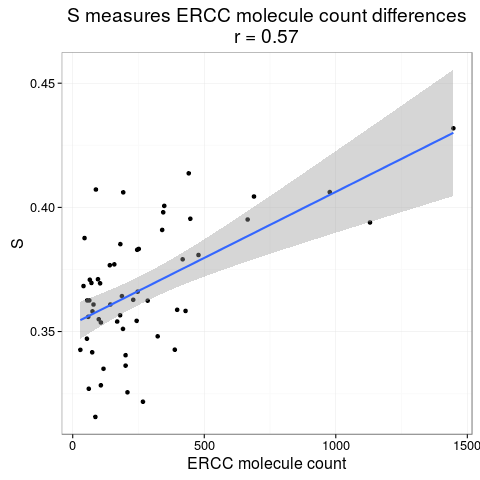

In [62]:
%%R
#png("S_vs_ERCC_Counts.png")
S_ERCC_count <- ggplot(parameters, aes(x = ercc_count, y = S)) +
  geom_point() +
  geom_smooth(method = "lm") +
  labs(x = "ERCC molecule count",
       title = paste0("S measures ERCC molecule count differences\nr = ",
                      round(cor(parameters$ercc_count, parameters$S), 2)))
S_ERCC_count

## $\phi$ vs $S$

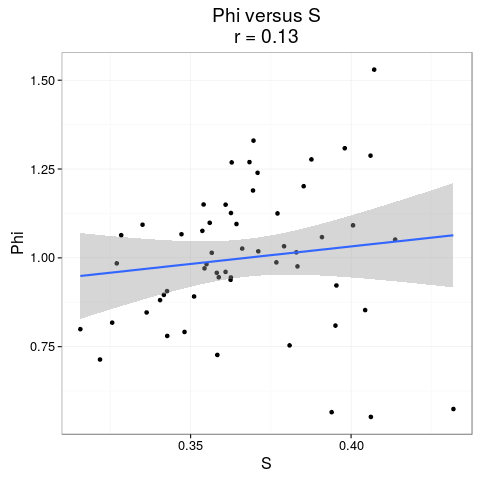

In [63]:
%%R
#png("phi_vs_S.png")
phi_s <- ggplot(parameters, aes(x = S, y = Phi)) +
  geom_point() +
  geom_smooth(method = "lm") +
  labs(       title = paste0("Phi versus S\nr = ",
                      round(cor(parameters$S, parameters$Phi), 2)))
phi_s

## Denoised data

The function `BASiCS_DenoisedCounts(Data=Data, Chain = MCMC_Output)` produce a matrix of normalized counts for which the effect of technical variation is removed 

For each gene $i$ and cell $j$ this function returns

$$ x^*_{ij} = \frac{ x_{ij} } {\hat{\phi}_j \hat{\nu}_j}, $$

where $x_{ij}$ is the observed expression count of gene $i$ in cell $j$, $\hat{\phi}_j$ denotes the posterior median of $\phi_j$ and $\hat{\nu}_j$ is the posterior median of $\nu_j$.

Remove technical noise (i.e. normalize using the ERCC spike-ins). This takes a long time!

In [64]:
%%R
denoised = BASiCS_DenoisedCounts(Data = basics_data, Chain = mcmc_output)
write.table(denoised, "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/BASiCS_OUTPUT_V2/basics-denoised.txt", quote = FALSE,
            sep = "\t", col.names = NA)

Alternativelly, the user can compute the normalised and denoised expression rates underlying the expression of all genes across cells using `BASiCS_DenoisedRates`. The output of this function is given by 

$$ \Lambda_{ij} = \hat{\mu_i} \hat{\rho}_{ij},  $$

where $\hat{\mu_i}$ represents the posterior median of $\mu_j$ and $\hat{\rho}_{ij}$ is given by its posterior mean (Monte Carlo estimate based on the MCMC sample of all model parameters).

In [65]:
%%R
denoised_rates = BASiCS_DenoisedRates(Data = basics_data, Chain = mcmc_output)
write.table(denoised_rates, "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/BASiCS_OUTPUT_V2/basics-denoised-rates.txt", quote = FALSE,
            sep = "\t", col.names = NA)

[1] "This calculation requires a loop across the 2000 MCMC iterations"
[1] "Please be patient ... "

[1] "To see a progress report use PrintProgress = TRUE"



In [67]:
%%R
GeneAnnotation <- read.table('/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/GeneAnnotation.csv', header=TRUE, sep=",")

In [74]:
%%R
head(GeneAnnotation[,1])

[1] ENSMUSG00000000001.4  ENSMUSG00000000003.12 ENSMUSG00000000028.11
[4] ENSMUSG00000000031.12 ENSMUSG00000000037.13 ENSMUSG00000000049.8 
45232 Levels: ENSMUSG00000000001.4 ENSMUSG00000000003.12 ... ENSMUSG00000106671.1


In [86]:
%%R
denoisedAnnotation <- GeneAnnotation[GeneAnnotation$exon_parent %in% rownames(denoised),]
# denoisedAnnotation <- rbind(denoisedAnnotation, SpikeExp)
denoisedAnnotatedCount <- cbind(denoisedAnnotation, denoised[1:(dim(denoised)[1] - dim(SpikeExp)[1]),])
write.table(denoisedAnnotatedCount, "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/BASiCS_OUTPUT_V2/DenoisedAnnotated.txt", quote = FALSE, sep = "\t", col.names = NA)


In [82]:
%%R
dim(denoisedAnnotatedCount)

[1] 9832   66


Chekcing for the Convergence

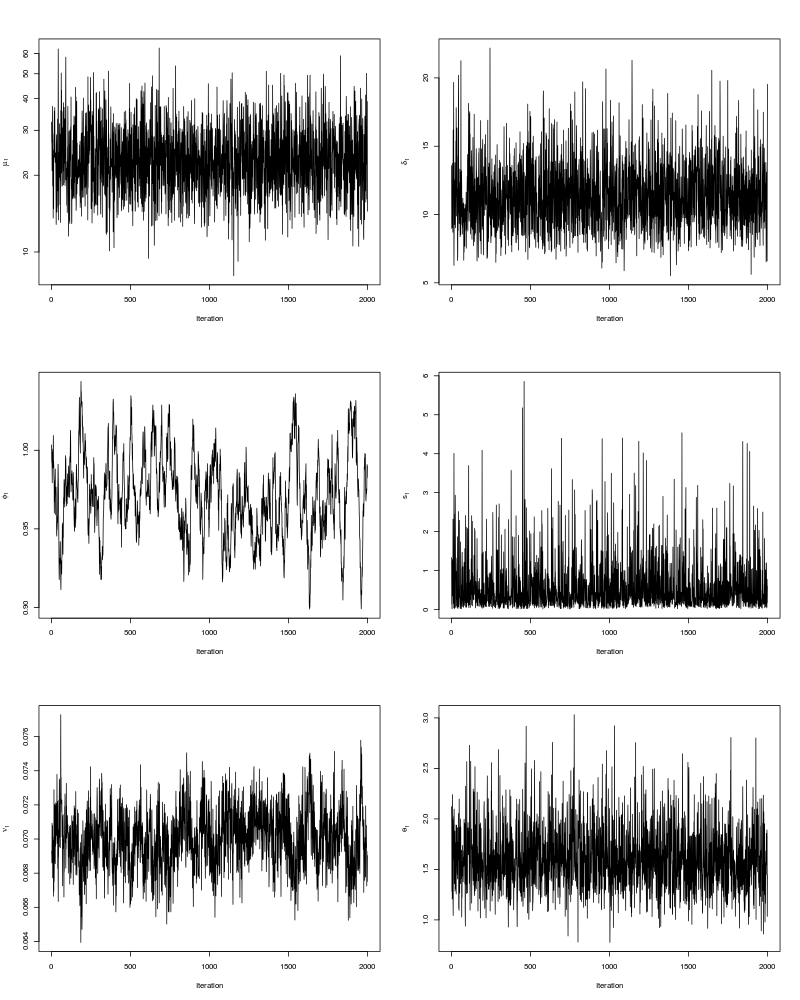

In [87]:
%%R -w 800 -h 1000
par(mfrow=c(3,2))
plot(mcmc_output, Param = "mu", Gene = 1, log = "y")
plot(mcmc_output, Param = "delta", Gene = 1)
plot(mcmc_output, Param = "phi", Cell = 1)
plot(mcmc_output, Param = "s", Cell= 1)
plot(mcmc_output, Param = "nu", Cell = 1)
plot(mcmc_output, Param = "theta", Batch = 1)

__PCA Plotting with Normalized Dataset__

This plot is generated taking both the gene counts and the ERCC spike in counts

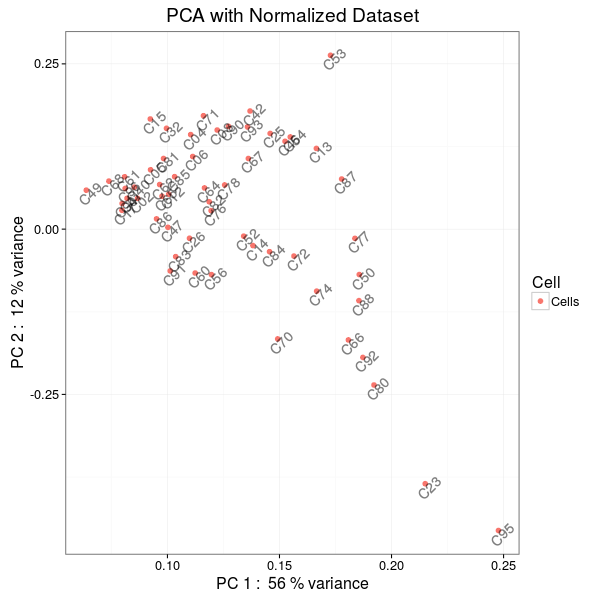

In [90]:
%%R -w 600 -h 600
FinalPCAData <- denoised
# # Used this function to save the file in pdf format
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
strain <- factor(c(rep("Cells", dim(denoised)[2])), levels=c("Cells"), labels=c("Cells"))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy],Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with Normalized Dataset")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
p<-p + geom_text(data=df,aes(label=colnames(denoised)),alpha=0.5,size=5, vjust=1,hjust=0.5,angle=45, color="black")
print(p)

__PCA plotting with the raw data__

This plot is generated taking both the gene counts and the ERCC spike in counts

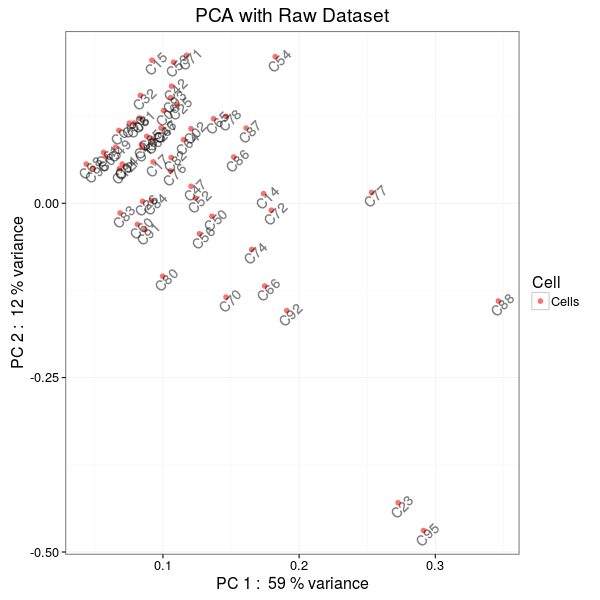

In [92]:
%%R -w 600 -h 600
FinalPCAData <- Counts
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
#png("PCA with Raw Data.png")
strain <- factor(c(rep("Cells", dim(cd)[2])), levels=c("Cells"), labels=c("Cells"))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy],Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with Raw Dataset")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
p<-p + geom_text(data=df,aes(label=colnames(cd)),alpha=0.5,size=5, vjust=1,hjust=0.5,angle=45, color="black")
print(p)

__Gene Expression per cell__

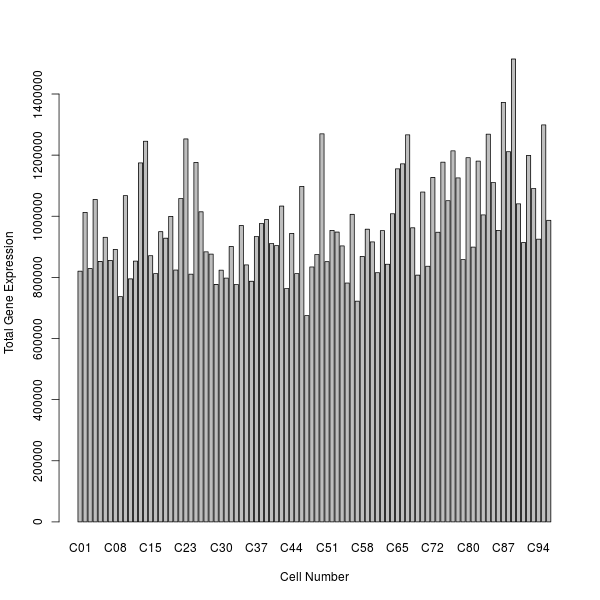

In [266]:
%%R -w 600 -h 600
CellGeneExpression <- colSums(denoised_rates)
barplot(CellGeneExpression,xlab="Cell Number", ylab="Total Gene Expression")

## SCDE for Heterogeneity analysis

The pagoda routines implemented in the scde resolves multiple, potentially overlapping aspects of transcriptional heterogeneity by identifying known pathways or novel gene sets that show significant excess of coordinated variability among the measured cells. Briefly, cell-specific error models derived from scde are used to estimate residual gene expression variance, and identify pathways and gene sets that exhibit statistically significant excess of coordinated variability (overdispersion). pagoda can be used to effectively recover known subpopulations and discover putative new subpopulations and their corresponding functional characteristics in single-cell samples. For more information, please refer to the original manuscript by [Fan et al](http://www.nature.com/nmeth/journal/vaop/ncurrent/full/nmeth.3734.html)

### Fitting error models

Next, we'll construct error models for individual cells. Here, we use k-nearest neighbor model fitting procedure implemented by `knn.error.models()` method. Our data is a UMI based data, so we raise the min.count.threshold to 1 (minimum number of reads for the gene to be initially classified as a non-failed measurement), requiring at least 5 non-failed measurements per gene. We're providing a rough guess to the complexity of the population, by fitting the error models based on 1/4 of most similar cells (i.e. guessing there might be ~4 subpopulations).

Note this step takes a considerable amount of time unless multiple cores are used. We highly recommend use of multiple cores. You can check the number of available cores available using `parallel::detectCores()`

__We had to use the raw data for this as SCDE does not accept normalized data__

In [250]:
%%R
knn <- knn.error.models(cd, k = ncol(cd)/4, n.cores = 2, min.count.threshold = 1, min.nonfailed = 5, save.model.plots = TRUE, max.model.plots = 50)

The fitting process above wrote out `cell.models.pdf` file in the current directory showing model fits for the first 50 cells

### Normalizing variance
In order to accurately quantify excess variance or overdispersion, we must normalize out expected levels of technical and intrinsic biological noise. Briefly, variance of the NB/Poisson mixture processes derived from the error modeling step are modeled as a chi-squared distribution using adjusted degrees of freedom and observation weights based on the drop-out probability of a given gene. Here, we normalize variance, trimming 3 most extreme cells and limiting maximum adjusted variance to 5.

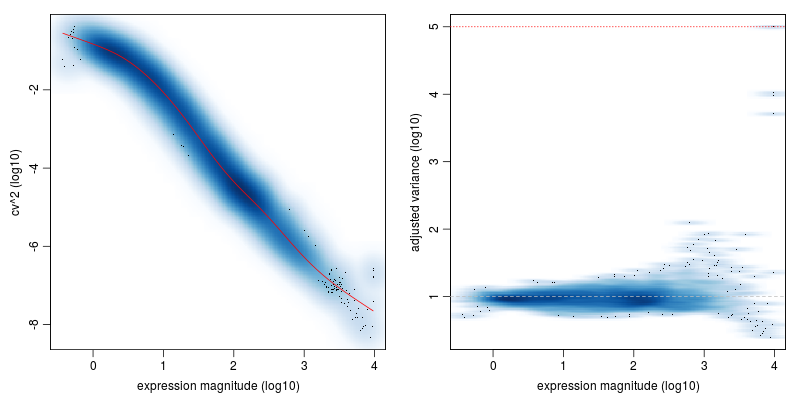

In [254]:
%%R -w 800 -h 400
options(repr.plot.width=6, repr.plot.height=4)
varinfo <- pagoda.varnorm(knn, counts = cd, trim = 3/ncol(cd), max.adj.var = 5, n.cores = 2, plot = TRUE)

The plot on the left shows coefficient of variance squared (on log10 scale) as a function of expression magnitude (log10 FPM). The red line shows local regression model for the genome-wide average dependency. The plot on the right shows adjusted variance (derived based on chi-squared probability of observed/genomewide expected ratio for each gene, with degrees of freedom adjusted for each gene). The adjusted variance of 1 means that a given gene exhibits as much variance as expected for a gene of such population average expression magnitude. Genes with high adjusted variance are overdispersed within the measured population and most likely show subpopulation-specific expression:

In [267]:
%%R
# list top overdispersed genes
sort(varinfo$arv, decreasing = TRUE)[1:10]

 ENSMUSG00000065037.1  ENSMUSG00000091405.2  ENSMUSG00000064351.1 
             5.000000              5.000000              4.019085 
 ENSMUSG00000064339.1  ENSMUSG00000064337.1 ENSMUSG00000027184.11 
             3.982810              3.709522              2.093697 
 ENSMUSG00000018930.3  ENSMUSG00000053560.4  ENSMUSG00000067017.5 
             1.934477              1.923176              1.915710 
 ENSMUSG00000069305.3 
             1.851245 


### Controlling for sequencing depth

Even with all the corrections, sequencing depth or gene coverage is typically still a major aspects of variability. In most studies, we would want to control for that as a technical artifact (exceptions are cell mixtures where subtypes significantly differ in the amount of total mRNA). Below we will control for the gene coverage (estimated as a number of genes with non-zero magnitude per cell) and normalize out that aspect of cell heterogeneity:

In [303]:
%%R
varinfo <- pagoda.subtract.aspect(varinfo, colSums(cd[, rownames(knn)]>0))

### Evaluate overdispersion of pre-defined gene sets

In order to detect significant aspects of heterogeneity across the population of single cells, 'pagoda' identifies pathways and gene sets that exhibit statistically significant excess of coordinated variability. Specifically, for each gene set, we tested whether the amount of variance explained by the first principal component significantly exceed the background expectation. 

__ Using Ensembl's BioMart service to get the GO annotations__

In [284]:
%%R
# Initialize the connection to the Ensembl BioMart Service
# Available datasets can be listed with 
# listDatasets(useMart("ENSEMBL_MART_ENSEMBL", host="www.ensembl.org"))
# Use mmusculus_gene_ensembl for mouse
ensembl <- useMart("ENSEMBL_MART_ENSEMBL", dataset = "mmusculus_gene_ensembl", host="www.ensembl.org")

# Constructs a dataframe with two columns: hgnc_symbol and go_id
# If rownames are Ensembl IDs, use ensembl_gene_id as filter value
go <- getBM(attributes = c("ensembl_gene_id", "go_id"), filters = "ensembl_gene_id", values = gsub("\\..*","",rownames(cd)), mart = ensembl)

# Use the GO.db library to add a column with the GO-term to the dataframe
go$term <- Term(go$go_id)

# Create a named list of character vectors out of the df
s = split(go$ensembl_gene_id, paste(go$go_id,go$term))

# Saves the list as a R environment
go.env <- list2env(s)

# Test
class(go.env)

[1] "environment"


In [285]:
%%R
head(ls(go.env)) # Look at gene set names

[1] "GO:0000002 mitochondrial genome maintenance"                  
[2] "GO:0000003 reproduction"                                      
[3] "GO:0000010 trans-hexaprenyltranstransferase activity"         
[4] "GO:0000011 vacuole inheritance"                               
[5] "GO:0000012 single strand break repair"                        
[6] "GO:0000014 single-stranded DNA endodeoxyribonuclease activity"


Now, we can calculate weighted first principal component magnitudes for each GO gene set in the provided environment.